In [1]:
import pandas as pd
df = pd.read_csv('training_data.csv')
df = df[df['label'] != 'push']
df.head()

,meanAx,sdAx,rangeAx,meanAy,sdAy,rangeAy,meanAz,sdAz,rangeAz,meanGx,sdGx,rangeGx,meanGy,sdGy,rangeGy,meanGz,sdGz,rangeGz,label,studentId
0,0.9679,0.2467,0.9634,-0.2738,0.1306,0.4613,-0.4429,0.2753,-0.9510,1.2329,27.7312,-91.0034,-193.0257,132.3646,-378.6621,-43.2414,39.3023,-116.0889,right,11804106
1,1.0147,0.3566,1.1539,-0.1511,0.1433,0.5248,-0.3760,0.1860,-0.6379,9.2285,48.6599,-174.6216,-224.4710,107.7086,-321.3501,-42.3299,32.3132,-90.0879,right,11804106
2,1.0819,0.4401,1.4689,-0.1490,0.0992,0.3985,-0.3194,0.3332,-1.1453,-16.8538,87.1097,-278.4424,-230.6885,121.5911,-391.1133,-65.8000,23.2705,-78.6743,right,11804106
3,1.0942,0.2780,0.9828,-0.2154,0.1880,0.6470,-0.3281,0.0928,-0.3226,-5.0741,86.1526,-310.6079,-225.2930,77.1939,-262.7563,-13.5213,45.0570,-167.6025,right,11804106
4,0.9802,0.3731,1.1923,-0.1418,0.1271,0.4563,-0.4507,0.1598,-0.5585,5.7170,42.9314,-132.3242,-208.9396,93.9282,-290.3442,-42.2892,22.3983,-83.6182,right,11804106


In [2]:
# Extract features and labels
feature_columns = ['meanAx', 'sdAx', 'rangeAx', 'meanAy', 'sdAy', 'rangeAy', 
                   'meanAz', 'sdAz', 'rangeAz', 'meanGx', 'sdGx', 'rangeGx', 
                   'meanGy', 'sdGy', 'rangeGy', 'meanGz', 'sdGz', 'rangeGz']

X = df[feature_columns]
y = df['label']

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Unique labels: {y.unique()}")

Features shape: (713, 18)
Labels shape: (713,)
Unique labels: ['right' 'left' 'up' 'down']


In [3]:
# Check class distribution BEFORE encoding
print("\n=== CLASS DISTRIBUTION ===")
label_counts = df['label'].value_counts()
print(label_counts)
print(f"\nTotal samples: {len(df)}")


=== CLASS DISTRIBUTION ===
label
right    199
left     194
down     164
up       156
Name: count, dtype: int64

Total samples: 713


In [4]:
def encode_label(lbl):
    # Convert label to lowercase to handle inconsistencies like 'Right' vs 'right'
    lbl_lower = str(lbl).lower()
    label_map = {'right': 0, 'left': 1,  'up': 2, 'down': 3, 'push': 4}
    return label_map.get(lbl_lower, -1)

df['label'] = df['label'].apply(encode_label)

# IMPORTANT: Re-extract y AFTER encoding to numeric values
y = df['label']

# Verify that there are no -1 labels
if -1 in y.unique():
    print("ERROR: Found -1 in labels after encoding. Check for unexpected label strings.")
    print(df[df['label'] == -1])
else:
    print(f"OK: Encoded labels are: {y.unique()}")
    
print(f"Label type: {type(y.iloc[0])}")

OK: Encoded labels are: [0 1 2 3]
Label type: <class 'numpy.int64'>


In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Normalization will be done after train-test split to avoid data leakage

In [6]:
from sklearn.model_selection import train_test_split

# First split: separate test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Second split: separate validation set from remaining data (25% of total = ~22% of temp)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Fit scaler on training data only
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Training set: 427 samples
Validation set: 143 samples
Test set: 143 samples


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Hyperparameter tuning using validation set
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 'scale']
}

svm_base = SVC(kernel='rbf', class_weight='balanced', probability=True, decision_function_shape='ovo')

print("Performing hyperparameter tuning on validation set...")
grid_search = GridSearchCV(svm_base, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best validation accuracy: {grid_search.best_score_:.4f}")

# Use best model
svm_model = grid_search.best_estimator_

# Evaluate best model on validation set
val_accuracy = svm_model.score(X_val, y_val)
print(f"Best model validation accuracy: {val_accuracy:.4f}")

NameError: name 'SVC' is not defined

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluate on all sets
sets = [
    ("Training", X_train, y_train),
    ("Validation", X_val, y_val),
    ("Test", X_test, y_test)
]

for set_name, X_set, y_set in sets:
    y_pred = svm_model.predict(X_set)
    print(f"\n=== {set_name.upper()} SET RESULTS ===")
    print(f"Accuracy: {accuracy_score(y_set, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_set, y_pred, target_names=['right', 'left', 'up', 'down']))


=== TRAINING SET RESULTS ===
Accuracy: 0.9625
Classification Report:
              precision    recall  f1-score   support

       right       0.96      0.92      0.94       119
        left       0.93      0.97      0.95       116
          up       0.99      0.98      0.98        94
        down       0.99      0.99      0.99        98

    accuracy                           0.96       427
   macro avg       0.97      0.96      0.96       427
weighted avg       0.96      0.96      0.96       427


=== VALIDATION SET RESULTS ===
Accuracy: 0.9021
Classification Report:
              precision    recall  f1-score   support

       right       0.87      0.82      0.85        40
        left       0.84      0.95      0.89        39
          up       0.96      0.87      0.92        31
        down       0.97      0.97      0.97        33

    accuracy                           0.90       143
   macro avg       0.91      0.90      0.91       143
weighted avg       0.91      0.90      0.90

In [ ]:
import pickle
with open('svm_model.pkl', 'wb') as file:
    pickle.dump(svm_model, file)
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [ ]:
# Analyze decision confidence for each class
print("\n=== DECISION FUNCTION ANALYSIS ===")
decision_scores = svm_model.decision_function(X_test)
probabilities = svm_model.predict_proba(X_test)

label_names = {0: 'right', 1: 'left', 2: 'up', 3: 'down'}

for i in range(min(5, len(X_test))):
    actual = label_names[y_test.iloc[i]]
    predicted = label_names[svm_model.predict(X_test[i:i+1])[0]]
    confidence = max(probabilities[i]) * 100
    print(f"\nSample {i}: Actual={actual}, Predicted={predicted}, Confidence={confidence:.1f}%")
    print(f"  Probabilities: {dict(zip([label_names[j] for j in range(4)], probabilities[i]))}")


=== DECISION FUNCTION ANALYSIS ===

Sample 0: Actual=down, Predicted=down, Confidence=98.9%
  Probabilities: {'right': np.float64(0.007016040923738508), 'left': np.float64(0.0018145397147789615), 'up': np.float64(0.0018682231443665179), 'down': np.float64(0.9893011962171162)}

Sample 1: Actual=down, Predicted=down, Confidence=77.7%
  Probabilities: {'right': np.float64(0.15251861238974299), 'left': np.float64(0.04140281066805608), 'up': np.float64(0.029058956728209902), 'down': np.float64(0.7770196202139912)}

Sample 2: Actual=right, Predicted=right, Confidence=96.5%
  Probabilities: {'right': np.float64(0.9646316852021012), 'left': np.float64(0.014502720769049213), 'up': np.float64(0.019946333756179317), 'down': np.float64(0.0009192602726701643)}

Sample 3: Actual=up, Predicted=up, Confidence=83.0%
  Probabilities: {'right': np.float64(0.11798351684204683), 'left': np.float64(0.02106123251321996), 'up': np.float64(0.8300062456386168), 'down': np.float64(0.030949005006116435)}

Sample

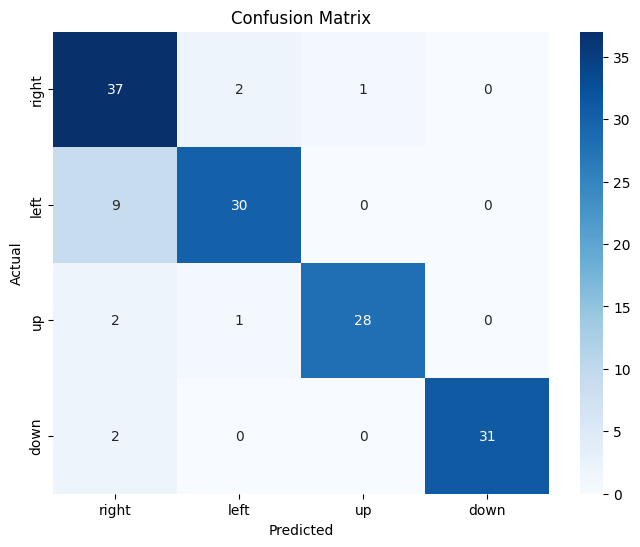

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['right', 'left', 'up', 'down'], 
            yticklabels=['right', 'left', 'up', 'down'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()